# ✅ Сравним собственную реализацию дерева с scikit-learn

## ⭐ Импорты

In [1]:
from time import time

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as tree_sk
from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns

from upninja.models.Trees.DecisionTreeClassifier import DecisionTreeClassifier as tree_my

/Users/romanseleznyov/Documents/UpliftNinja/main-env/lib/python3.13/site-packages/hyperopt/atpe.py:19: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [2]:
SEED = 8

## ⭐ Подготовим данные

In [3]:
dataset = pd.read_csv('data/breast-cancer.csv')
dataset.drop('id', axis=1, inplace=True)
dataset['diagnosis'] = (dataset['diagnosis'] == 'M').astype(int)

cor_target = abs(dataset.corr()['diagnosis'])
relevant_features = cor_target[cor_target>0.25]
names = [index for index, value in relevant_features.items()]
names.remove('diagnosis')

X = dataset[names].values
y = dataset['diagnosis'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=0.2)

## ⭐ Собственная реализация

In [4]:

my_tree = tree_my(min_samples=10,
                  max_depth=5
                 )

start_time = time()
my_tree.fit(X_train, y_train)
end_time = time()
pred = my_tree.predict(X_test)
print('⌛Fit time: ', end_time - start_time, ' (seconds)')
print('🎯Accuracy: ', accuracy_score(y_test, pred))

⌛Fit time:  0.9799761772155762  (seconds)
🎯Accuracy:  0.9385964912280702


## ⭐ Scikit-learn

In [5]:
sk_tree = tree_sk(min_samples_leaf=10,
                  max_depth=5,
                  criterion='entropy'
                 )

start_time = time()
sk_tree.fit(X_train, y_train)
end_time = time()
pred = sk_tree.predict(X_test)
print('⌛Fit time: ', end_time - start_time, ' (seconds)')
print('🎯Accuracy: ', accuracy_score(y_test, pred))

⌛Fit time:  0.004411935806274414  (seconds)
🎯Accuracy:  0.9473684210526315


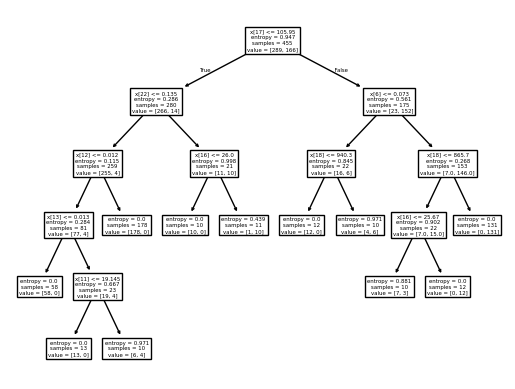

In [6]:
dt_plt = plot_tree(sk_tree)